<h1>GoJek App Reviewer</h1>
<b>Yeremia Maydinata Narana || 5026221068</b>

In this project, I will find find the most common complaints in Gojek Apps :)

Gunakan CUDA jika device memilikinya

In [4]:
!pip install tensorflow -q
!pip install tensorflow_hub -q
!pip install torch
!pip install xgboost -q

In [5]:
import torch 

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


# #1 Scrapping Data #
Scrapping data from Google Play Store using <b>google-play-scraper</b> library.

In [6]:
!pip install google_play_scraper -q
!pip install textblob -q
!pip install seaborn -q

In [7]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import seaborn styles explicitly
import seaborn as sns
# Apply the seaborn style before creating plots
sns.set_style("whitegrid")  # This line sets the Seaborn style

plt.rcParams["figure.figsize"] = (15,10)

In [8]:
#Android App Gojek from Google Play at
#https://play.google.com/store/apps/details?id=com.gojek.app
#The apps ID found in the link after id=com.gojek.app

from google_play_scraper import app, Sort, reviews_all

gojek_reviews = reviews_all(
    'com.gojek.app',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [9]:
df_gjkrev = pd.DataFrame(np.array(gojek_reviews),columns=['content'])
df_gjkrev = df_gjkrev.join(pd.DataFrame(df_gjkrev.pop('content').tolist()))

In [10]:
df_gjkrev
df_gjkrev.info()
df_gjkrev['score'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226472 entries, 0 to 226471
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              226472 non-null  object        
 1   userName              226472 non-null  object        
 2   userImage             226472 non-null  object        
 3   content               226437 non-null  object        
 4   score                 226472 non-null  int64         
 5   thumbsUpCount         226472 non-null  int64         
 6   reviewCreatedVersion  193791 non-null  object        
 7   at                    226472 non-null  datetime64[ns]
 8   replyContent          35192 non-null   object        
 9   repliedAt             35192 non-null   datetime64[ns]
 10  appVersion            193791 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 19.0+ MB


score
5    123361
1     51218
4     21979
3     15523
2     14391
Name: count, dtype: int64

In [11]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_gjkrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

content  score  \
0       VOCHER BANDARANYA SERING BANGET UDAH BISA KLAI...      1   
1                                                    good      4   
2       susah banget booking ,gak kayak ijo sebelah, m...      2   
3       some time good, other times bad. overall so so...      3   
4       kodee promonya makin sinii makin menurun, dari...      2   
...                                                   ...    ...   
226467                                      Love this app      5   
226468                              Akhirnya keluar juga!      5   
226469                                            Finally      5   
226470                                            Helpful      4   
226471                                     Usefull banget      5   

        thumbsUpCount reviewCreatedVersion                  at  \
0                   0               5.12.1 2025-10-13 08:39:46   
1                   0               5.34.2 2025-10-13 08:02:55   
2                   0               5.34.2 2025-10-13 06:20:15   
3                   0               5.34.2 2025-10-13 05:24:35   
4                   0                 None 2025-10-13 00:50:05   
...               ...                  ...                 ...   
226467              0                1.0.1 2014-12-31 04:11:06   
226468              0                1.0.1 2014-12-24 22:20:26   
226469              0                1.0.1 2014-12-23 12:04:16   
226470              0                 None 2014-12-20 23:41:52   
226471              1                 None 2014-12-19 22:00:21   

                                             replyContent           repliedAt  
0       Hai Kak @Proto twelve, mohon maaf atas ketidak... 2025-10-13 10:06:04  
1                                                    None                 NaT  
2       Mohon maaf atas kendala yang dialami, Kak Mari... 2025-10-13 07:51:06  
3                                                    None                 NaT  
4                                                    None                 NaT  
...                                                   ...                 ...  
226467                                               None                 NaT  
226468                                               None                 NaT  
226469                                               None                 NaT  
226470                                               None                 NaT  
226471                                               None                 NaT  

[226472 rows x 7 columns]

# #2 Preprocessing Data #

 ## Sentiment before Preprocessing ##

In [12]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_gjkrev['sentiment_rating'] = df_gjkrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [13]:
from textblob import TextBlob
df_gjkrev['sentiment_polarity'] = df_gjkrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_gjkrev['sentiment_subjective'] = df_gjkrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

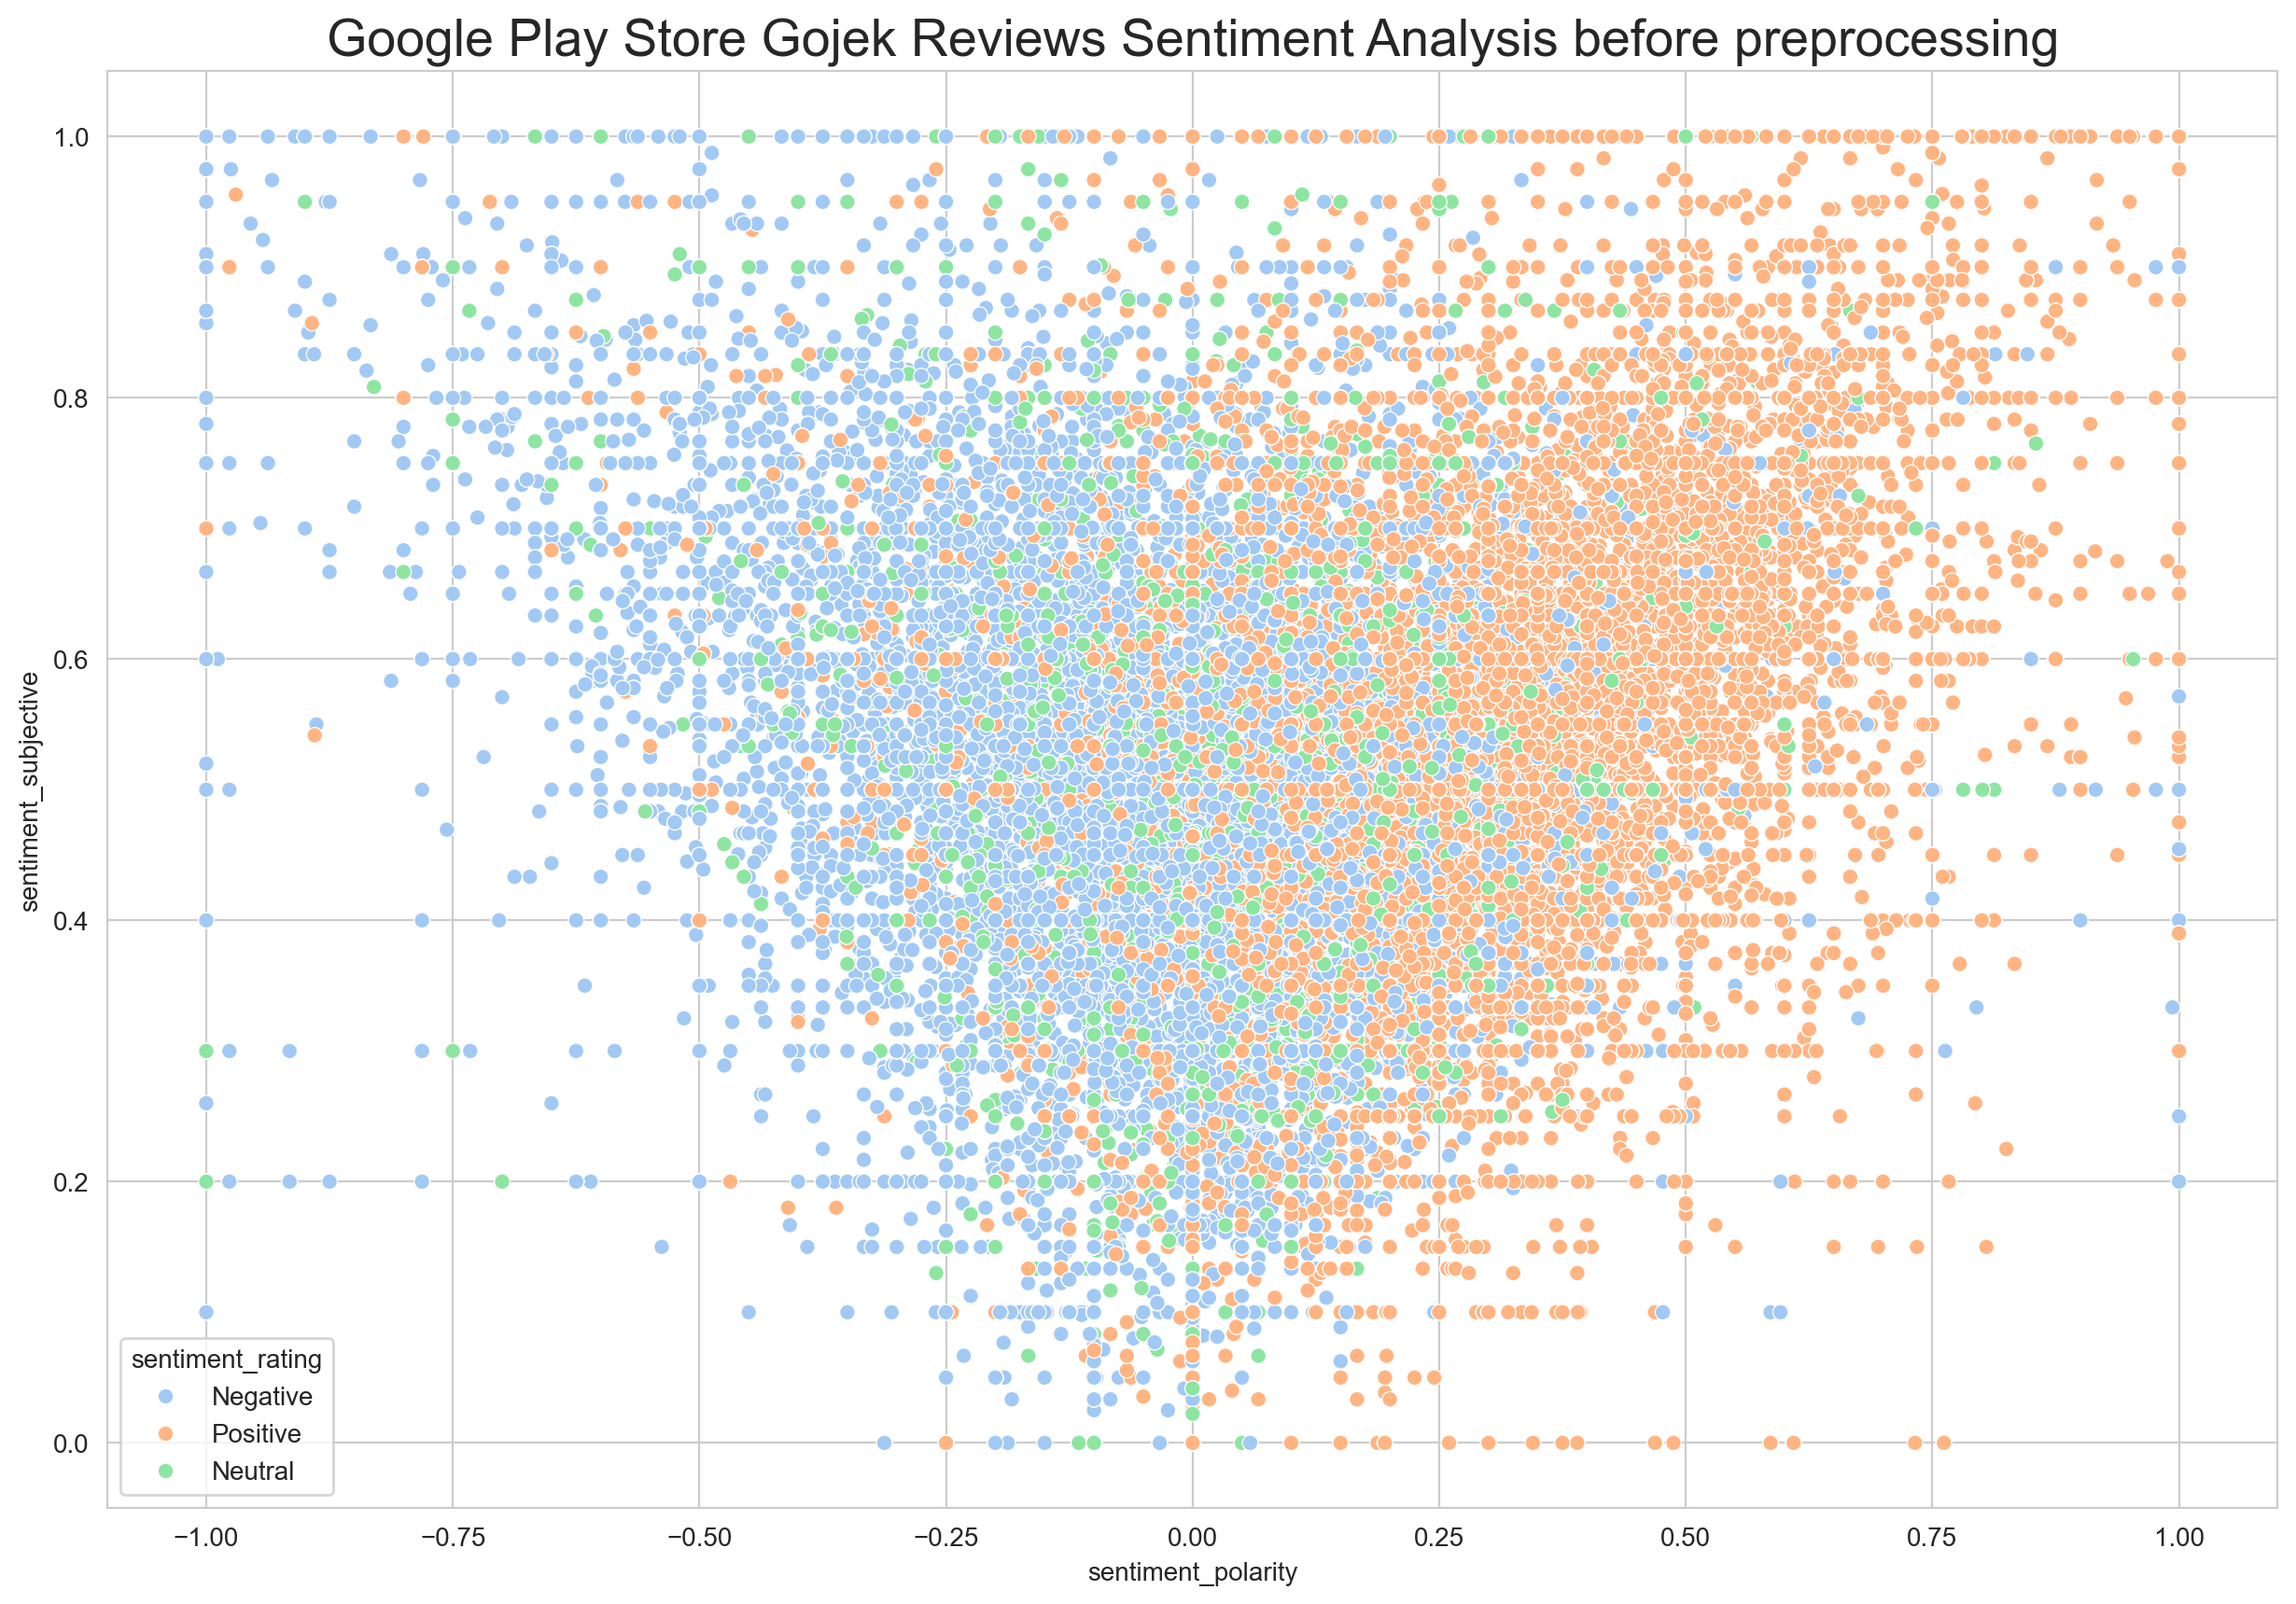

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_gjkrev['sentiment_polarity'], y=df_gjkrev['sentiment_subjective'],
                hue=df_gjkrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store Gojek Reviews Sentiment Analysis before preprocessing", fontsize=20)
plt.show()

In [15]:
!pip install emoji

In [16]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

## a. Lowercasing ##

In [17]:
# Lower casing
# Change the reviews type to string
df_gjkrev['content'] = df_gjkrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_gjkrev['content'][188])
print(df_gjkrev['content'][1])
print(df_gjkrev['content'][20100])

Promo-promo di akun saya tiba-tiba diblokir tanpa ada alasan yang jelas. Saya tidak merasa melakukan kecurangan apapun selama menggunakan aplikasi gojek ini yang membuat promo di akun saya diblokir. Saya sudah mecoba membuat laporan tetapi customer servicenya SANGAT sulit untuk dihubungi.
good
Mantap


In [18]:
#Lowercase all reviews to see the difference
df_gjkrev['content']= df_gjkrev['content'].apply(lambda x: x.lower())
print(df_gjkrev['content'][188])
print(df_gjkrev['content'][1])
print(df_gjkrev['content'][20100])

promo-promo di akun saya tiba-tiba diblokir tanpa ada alasan yang jelas. saya tidak merasa melakukan kecurangan apapun selama menggunakan aplikasi gojek ini yang membuat promo di akun saya diblokir. saya sudah mecoba membuat laporan tetapi customer servicenya sangat sulit untuk dihubungi.
good
mantap


In [19]:
df_gjkrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

content  \
0                                                            vocher bandaranya sering banget udah bisa klaim tapi gak muncul!   
1                                                                                                                        good   
2                       susah banget booking ,gak kayak ijo sebelah, muter2 doang lama, udah dapet driver banyakan gak gerak.   
3       some time good, other times bad. overall so so lah.. you guys already marked the market and it looks good on the map.   
4                              kodee promonya makin sinii makin menurun, dari 100 ke 70 skrg auto 50% doangg, kit atii tauuuu   
...                                                                                                                       ...   
226467                                                                                                          love this app   
226468                                                                                                  akhirnya keluar juga!   
226469                                                                                                                finally   
226470                                                                                                                helpful   
226471                                                                                                         usefull banget   

        score  sentiment_polarity  sentiment_subjective  
0           1              0.0000              0.000000  
1           4              0.7000              0.600000  
2           2              0.0000              0.000000  
3           3              0.1125              0.473611  
4           2              0.0000              0.000000  
...       ...                 ...                   ...  
226467      5              0.5000              0.600000  
226468      5              0.0000              0.000000  
226469      5              0.0000              1.000000  
226470      4              0.0000              0.000000  
226471      5              0.0000              0.000000  

[226472 rows x 4 columns]

## b. Stopwords Removal ##

In [20]:
!pip install Sastrawi

In [21]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get Indonesian stopwords
indonesian_stopwords = stopwords.words('indonesian')

# Display first 20 stopwords
print(indonesian_stopwords[:20])

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HiliCe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

df_gjkrev['wordCount'] = [len(review.split()) for review in df_gjkrev['content']]
df_gjkrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_gjkrev['content']]
df_gjkrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_gjkrev['content']]

In [23]:
# Assuming the text column is named 'text', update accordingly
text_column = 'content'  # Change this if the column has a different name

# Combine all text data into one string
all_text = ' '.join(df_gjkrev[text_column].dropna().astype(str))

# Tokenize words and remove stopwords
words = all_text.split()
filtered_words = [word.lower() for word in words if word.lower() not in indonesian_stopwords]

In [24]:
df_gjkrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

content  \
0                                                            vocher bandaranya sering banget udah bisa klaim tapi gak muncul!   
1                                                                                                                        good   
2                       susah banget booking ,gak kayak ijo sebelah, muter2 doang lama, udah dapet driver banyakan gak gerak.   
3       some time good, other times bad. overall so so lah.. you guys already marked the market and it looks good on the map.   
4                              kodee promonya makin sinii makin menurun, dari 100 ke 70 skrg auto 50% doangg, kit atii tauuuu   
...                                                                                                                       ...   
226467                                                                                                          love this app   
226468                                                                                                  akhirnya keluar juga!   
226469                                                                                                                finally   
226470                                                                                                                helpful   
226471                                                                                                         usefull banget   

        score  sentiment_polarity  sentiment_subjective  wordCount  \
0           1              0.0000              0.000000         10   
1           4              0.7000              0.600000          1   
2           2              0.0000              0.000000         16   
3           3              0.1125              0.473611         23   
4           2              0.0000              0.000000         17   
...       ...                 ...                   ...        ...   
226467      5              0.5000              0.600000          3   
226468      5              0.0000              0.000000          3   
226469      5              0.0000              1.000000          1   
226470      4              0.0000              0.000000          1   
226471      5              0.0000              0.000000          2   

        uppercaseCharCount  specialCharCount  
0                        0                 1  
1                        0                 0  
2                        0                 4  
3                        0                 5  
4                        0                 3  
...                    ...               ...  
226467                   0                 0  
226468                   0                 1  
226469                   0                 0  
226470                   0                 0  
226471                   0                 0  

[226472 rows x 7 columns]

In [25]:
# Indonesian Stopword Removal using Sastrawi
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Create stopword remover
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

sastrawi_stopwords = factory.get_stop_words()
print(f"There's total {len(sastrawi_stopwords)} Indonesian stopwords removed.")

There's total 126 Indonesian stopwords removed.


In [26]:
# English Stopword Removal using NLTK
# Get English stopwords
import nltk
nltk.download('stopwords')
english_stopwords = stopwords.words('english')

# To get the number of English stopwords, use the len() function:
print(f"There's total {len(english_stopwords)} English stopwords removed.")


There's total 198 English stopwords removed.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HiliCe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Apply stopword removal to the 'content' column
df_gjkrev['content'] = df_gjkrev['content'].apply(lambda x: stopword_remover.remove(x))

 ## c. Cleaning Text ##
(Include Stemming and Lemmatize)

In [28]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


# Create stemmer and lemmatizer objects
factory = StemmerFactory()
stemmer = factory.create_stemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HiliCe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HiliCe\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [29]:
def cleaning_text(text):
  # Menambah spasi setelah koma pada koma yang tidak diberi spasi
  text = re.sub(r",(?!\s)", ", ", text)
  # menghapus special character
  text = re.sub(r'[^\w\s]', ' ', text)
  # Menghapus tab, new line, back slice, dll
  text = text.replace('\\t', " ").replace('\\n', " ").replace('\\u', " ").replace('\\', "")
  # Menghapus karakter non ASCII (emoticon, chinese word, dll),
  text = text.encode('ascii', 'replace').decode('ascii')
  # Menghapus URL
  text = re.sub(r"(?i)(?:https?:\/\/)?(?:www\.)?(?:[a-zA-Z0-9-.]+)(?:\.[a-zA-Z]{2,6})(?:\/[^\s\r\n]*)?", "", text)
  # Menghapus angka
  text = re.sub(r"\d+", "", text)
  # Menghapus tanda baca
  text = text.translate(str.maketrans("", "", string.punctuation))
  # Menghapus whitespace di depan/belakang teks dan double++ spasi
  text = text.strip()
  text = re.sub('\s+', ' ', text)
  # Menghapus single character
  text = re.sub(r"\b[a-zA-Z]\b", "", text)
  # stemming
  text = stemmer.stem(text)
  # lemmatize
  words = text.split()
  lemmatized_words = [lemmatizer.lemmatize(word, 'v') for word in words]
  text = ' '.join(lemmatized_words)
  return text

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\HiliCe\AppData\Local\Temp\ipykernel_18964\992346851.py:18: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [ ]:
df_gjkrev.loc[:, 'clean'] = df_gjkrev['content'].apply(cleaning_text)

# Display the first few rows of the DataFrame with the cleaned reviews
print("DataFrame with cleaned reviews (first 5 rows):")
display(df_gjkrev[['content', 'clean']].head())

# #3 Hasil Review #

## a. Frequency Words ##

Word  Frequency
0      the      35214
1     good      29563
2       to      28108
3   driver      26737
4    gojek      24815
..     ...        ...
95     was       2983
96   harga       2923
97      or       2907
98    from       2906
99     get       2895

[100 rows x 2 columns]

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_22228\856327870.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


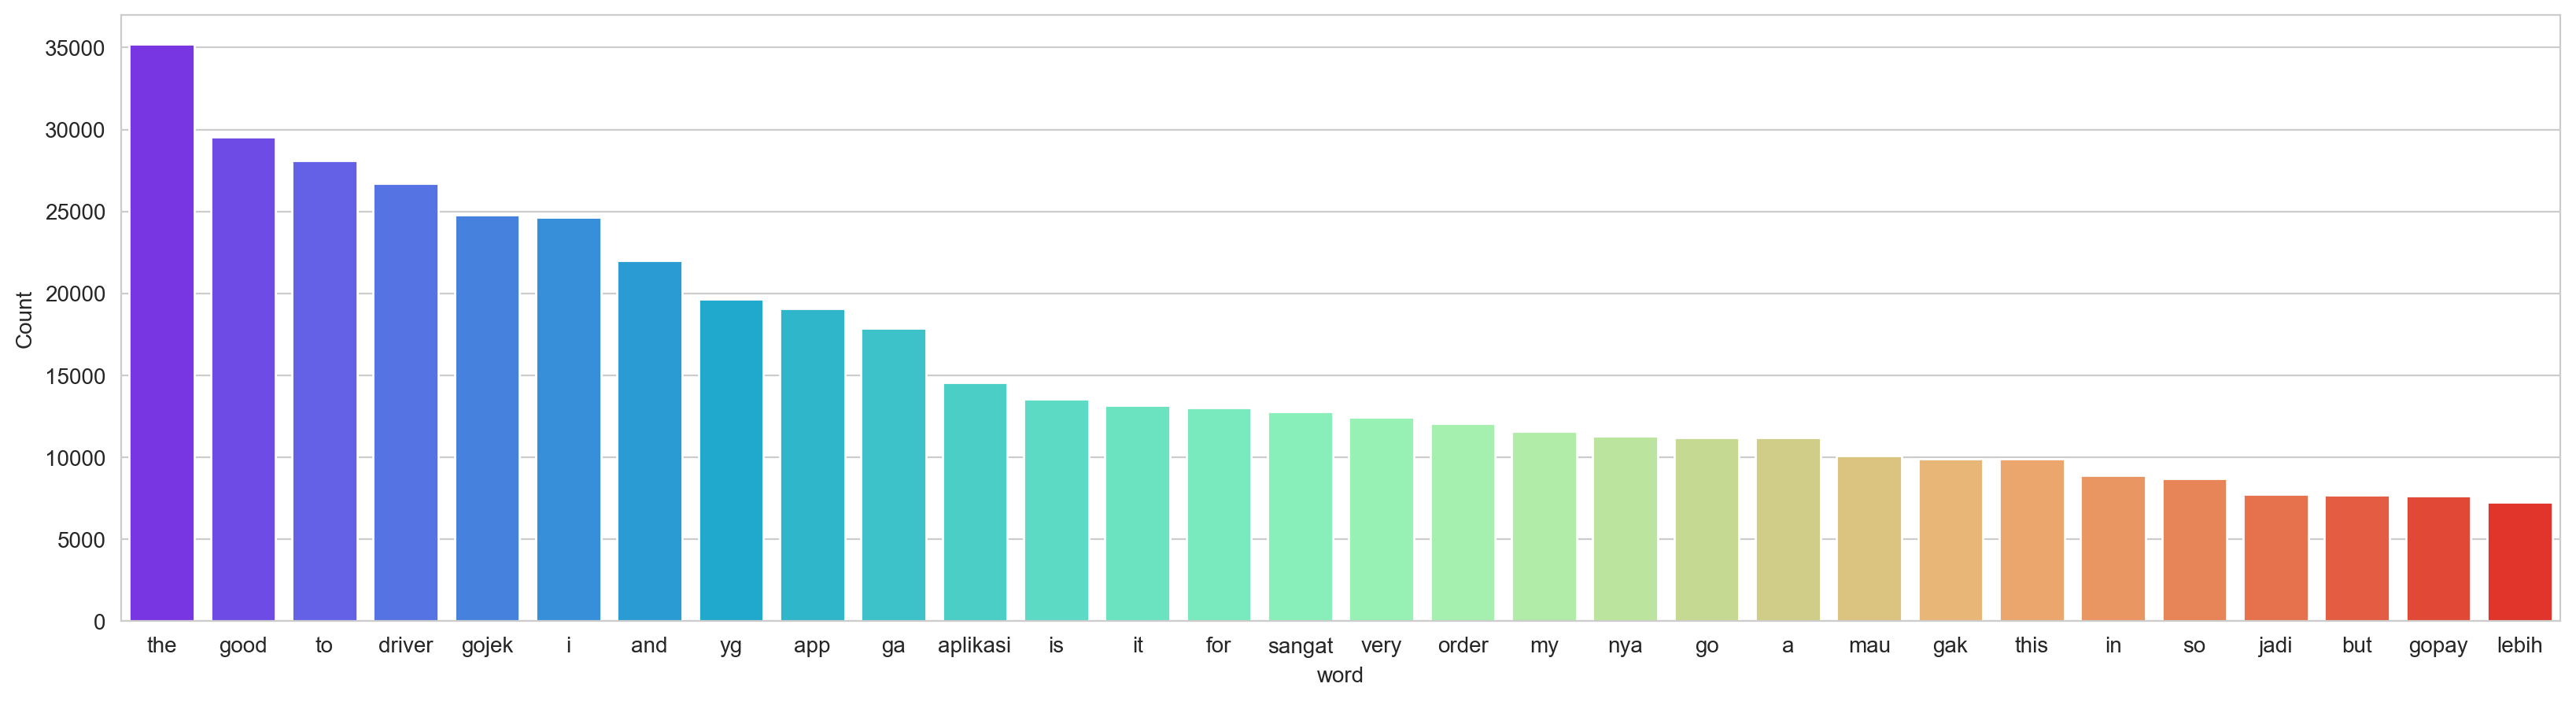

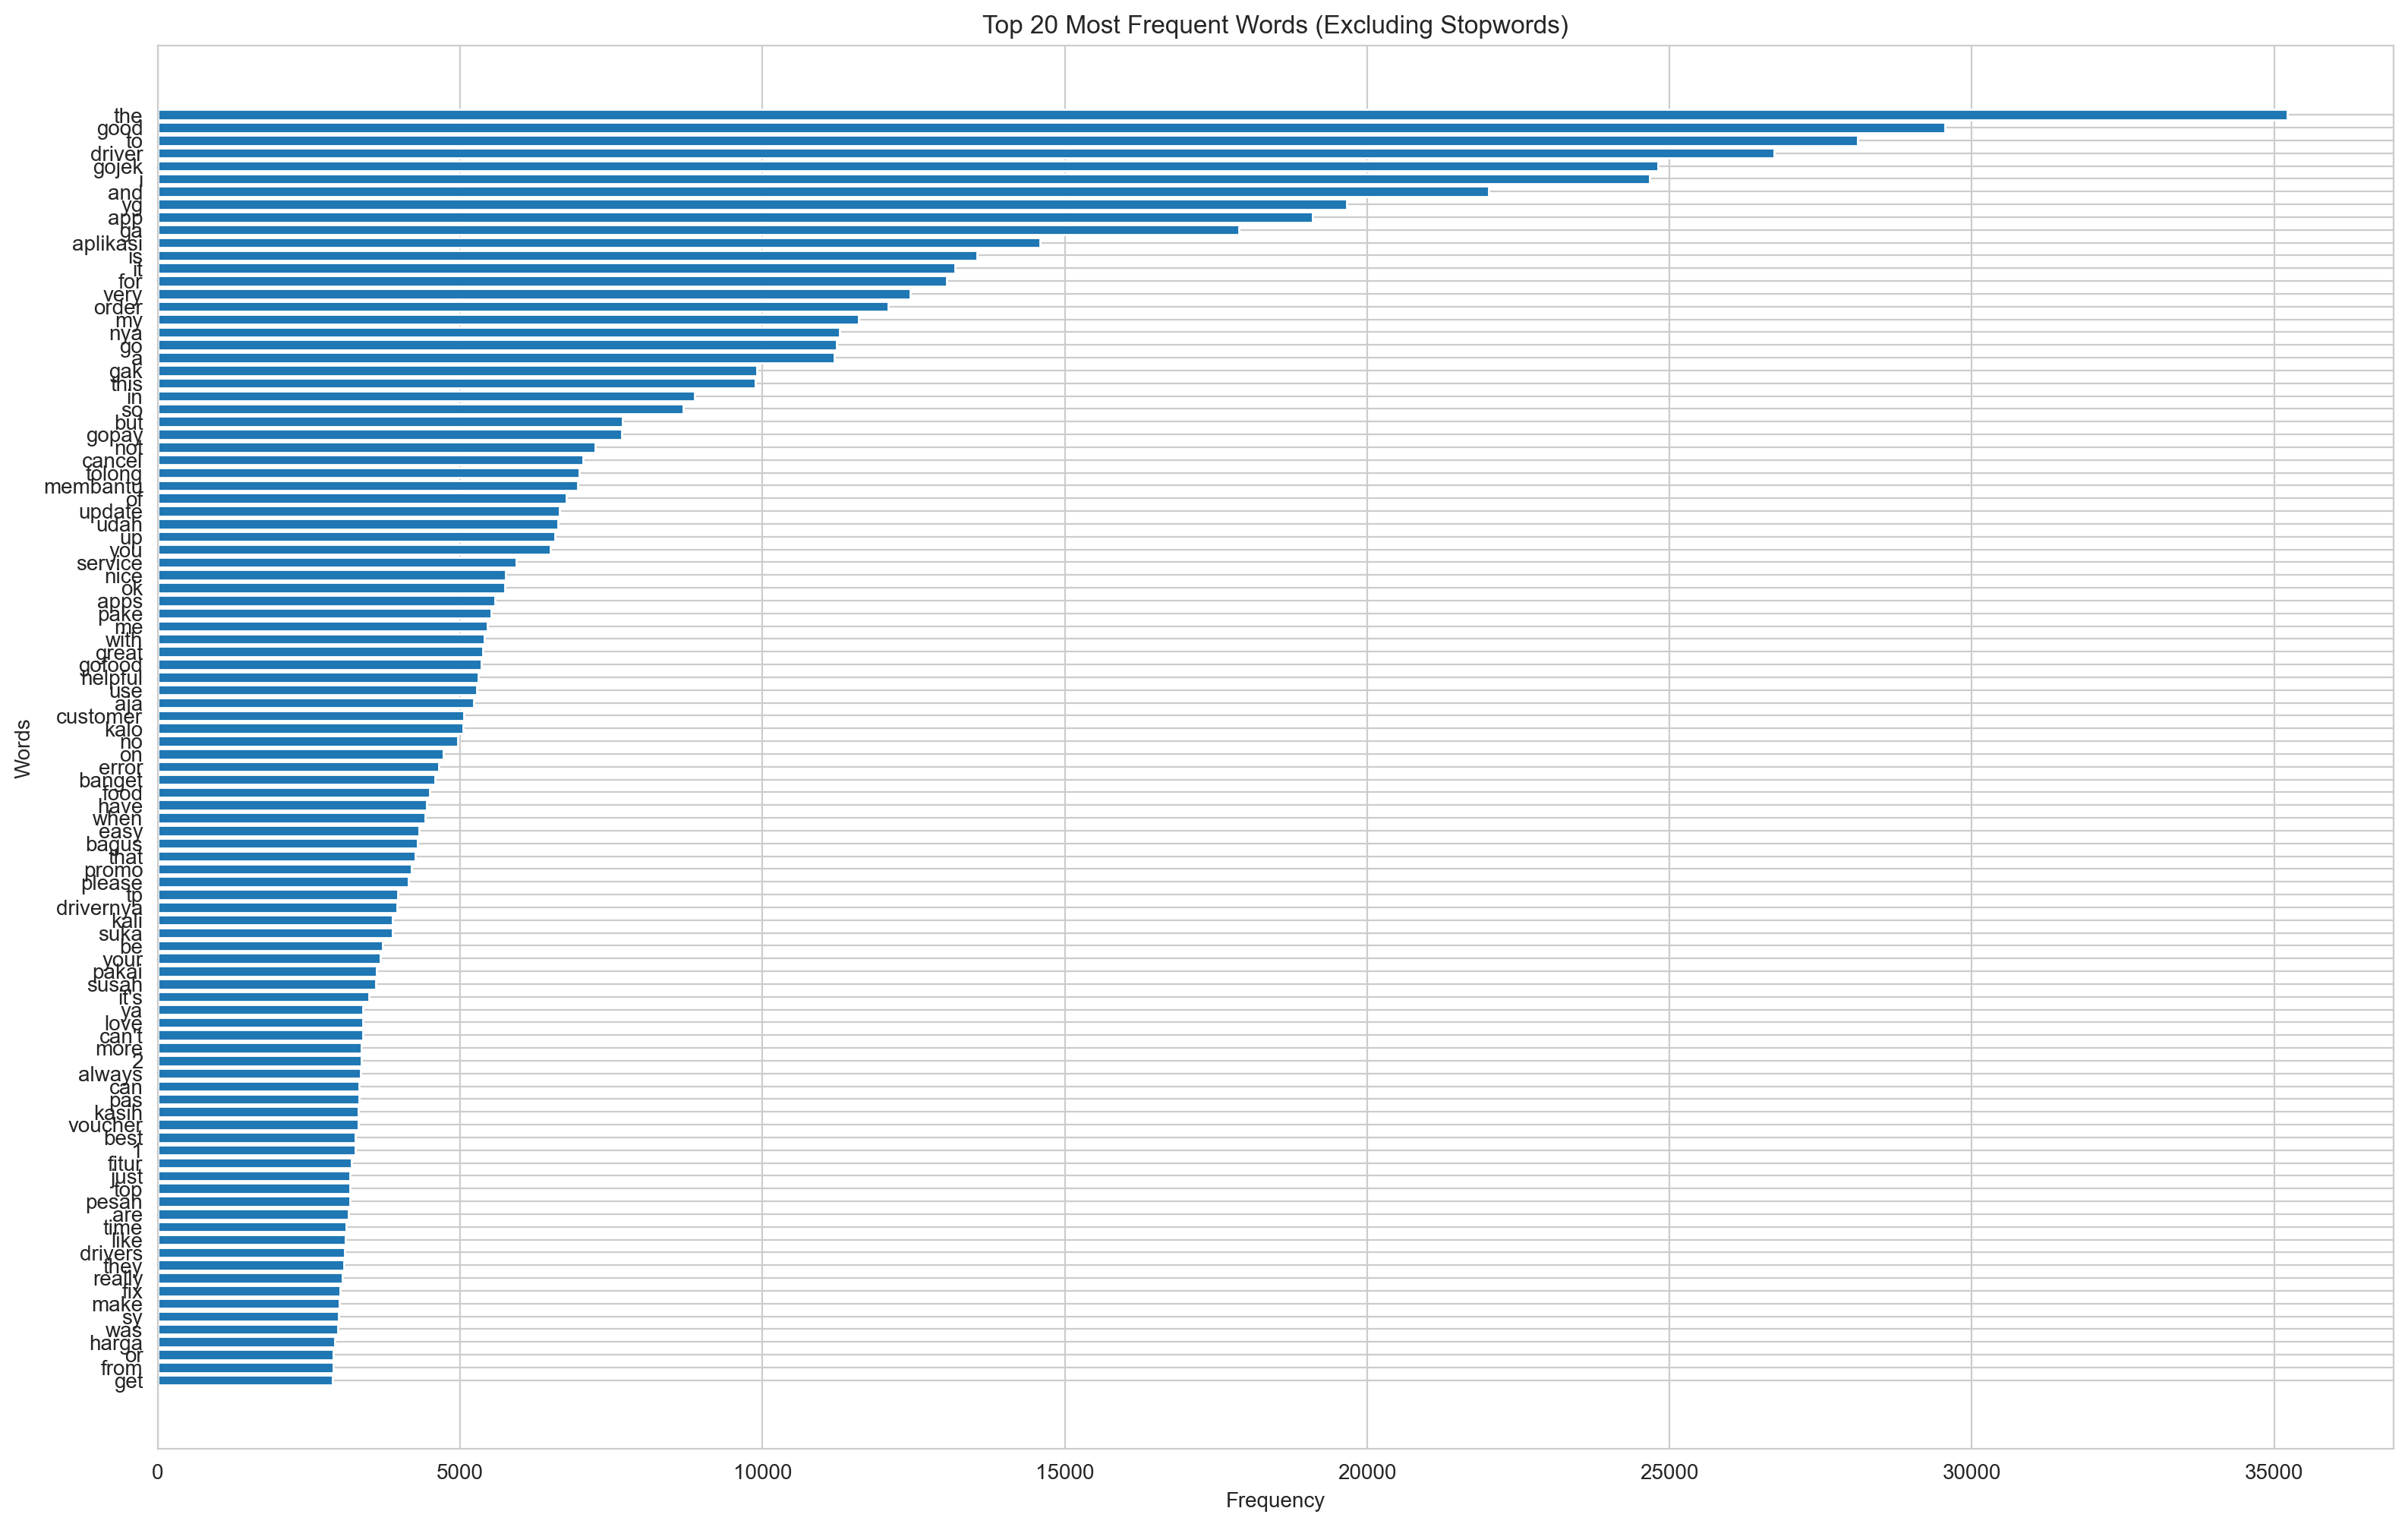

In [ ]:
# Count frequent words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(100)

# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Display the most common words
display(word_freq_df)

# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

# Plot the frequent words
freq_words(df_gjkrev['content'])
plt.figure(figsize=(19, 12))
plt.barh(word_freq_df['Word'][::-1], word_freq_df['Frequency'][::-1])
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Frequent Words (Excluding Stopwords)")
plt.show()

## c. Sentiment Analysis after Preprocessing ##

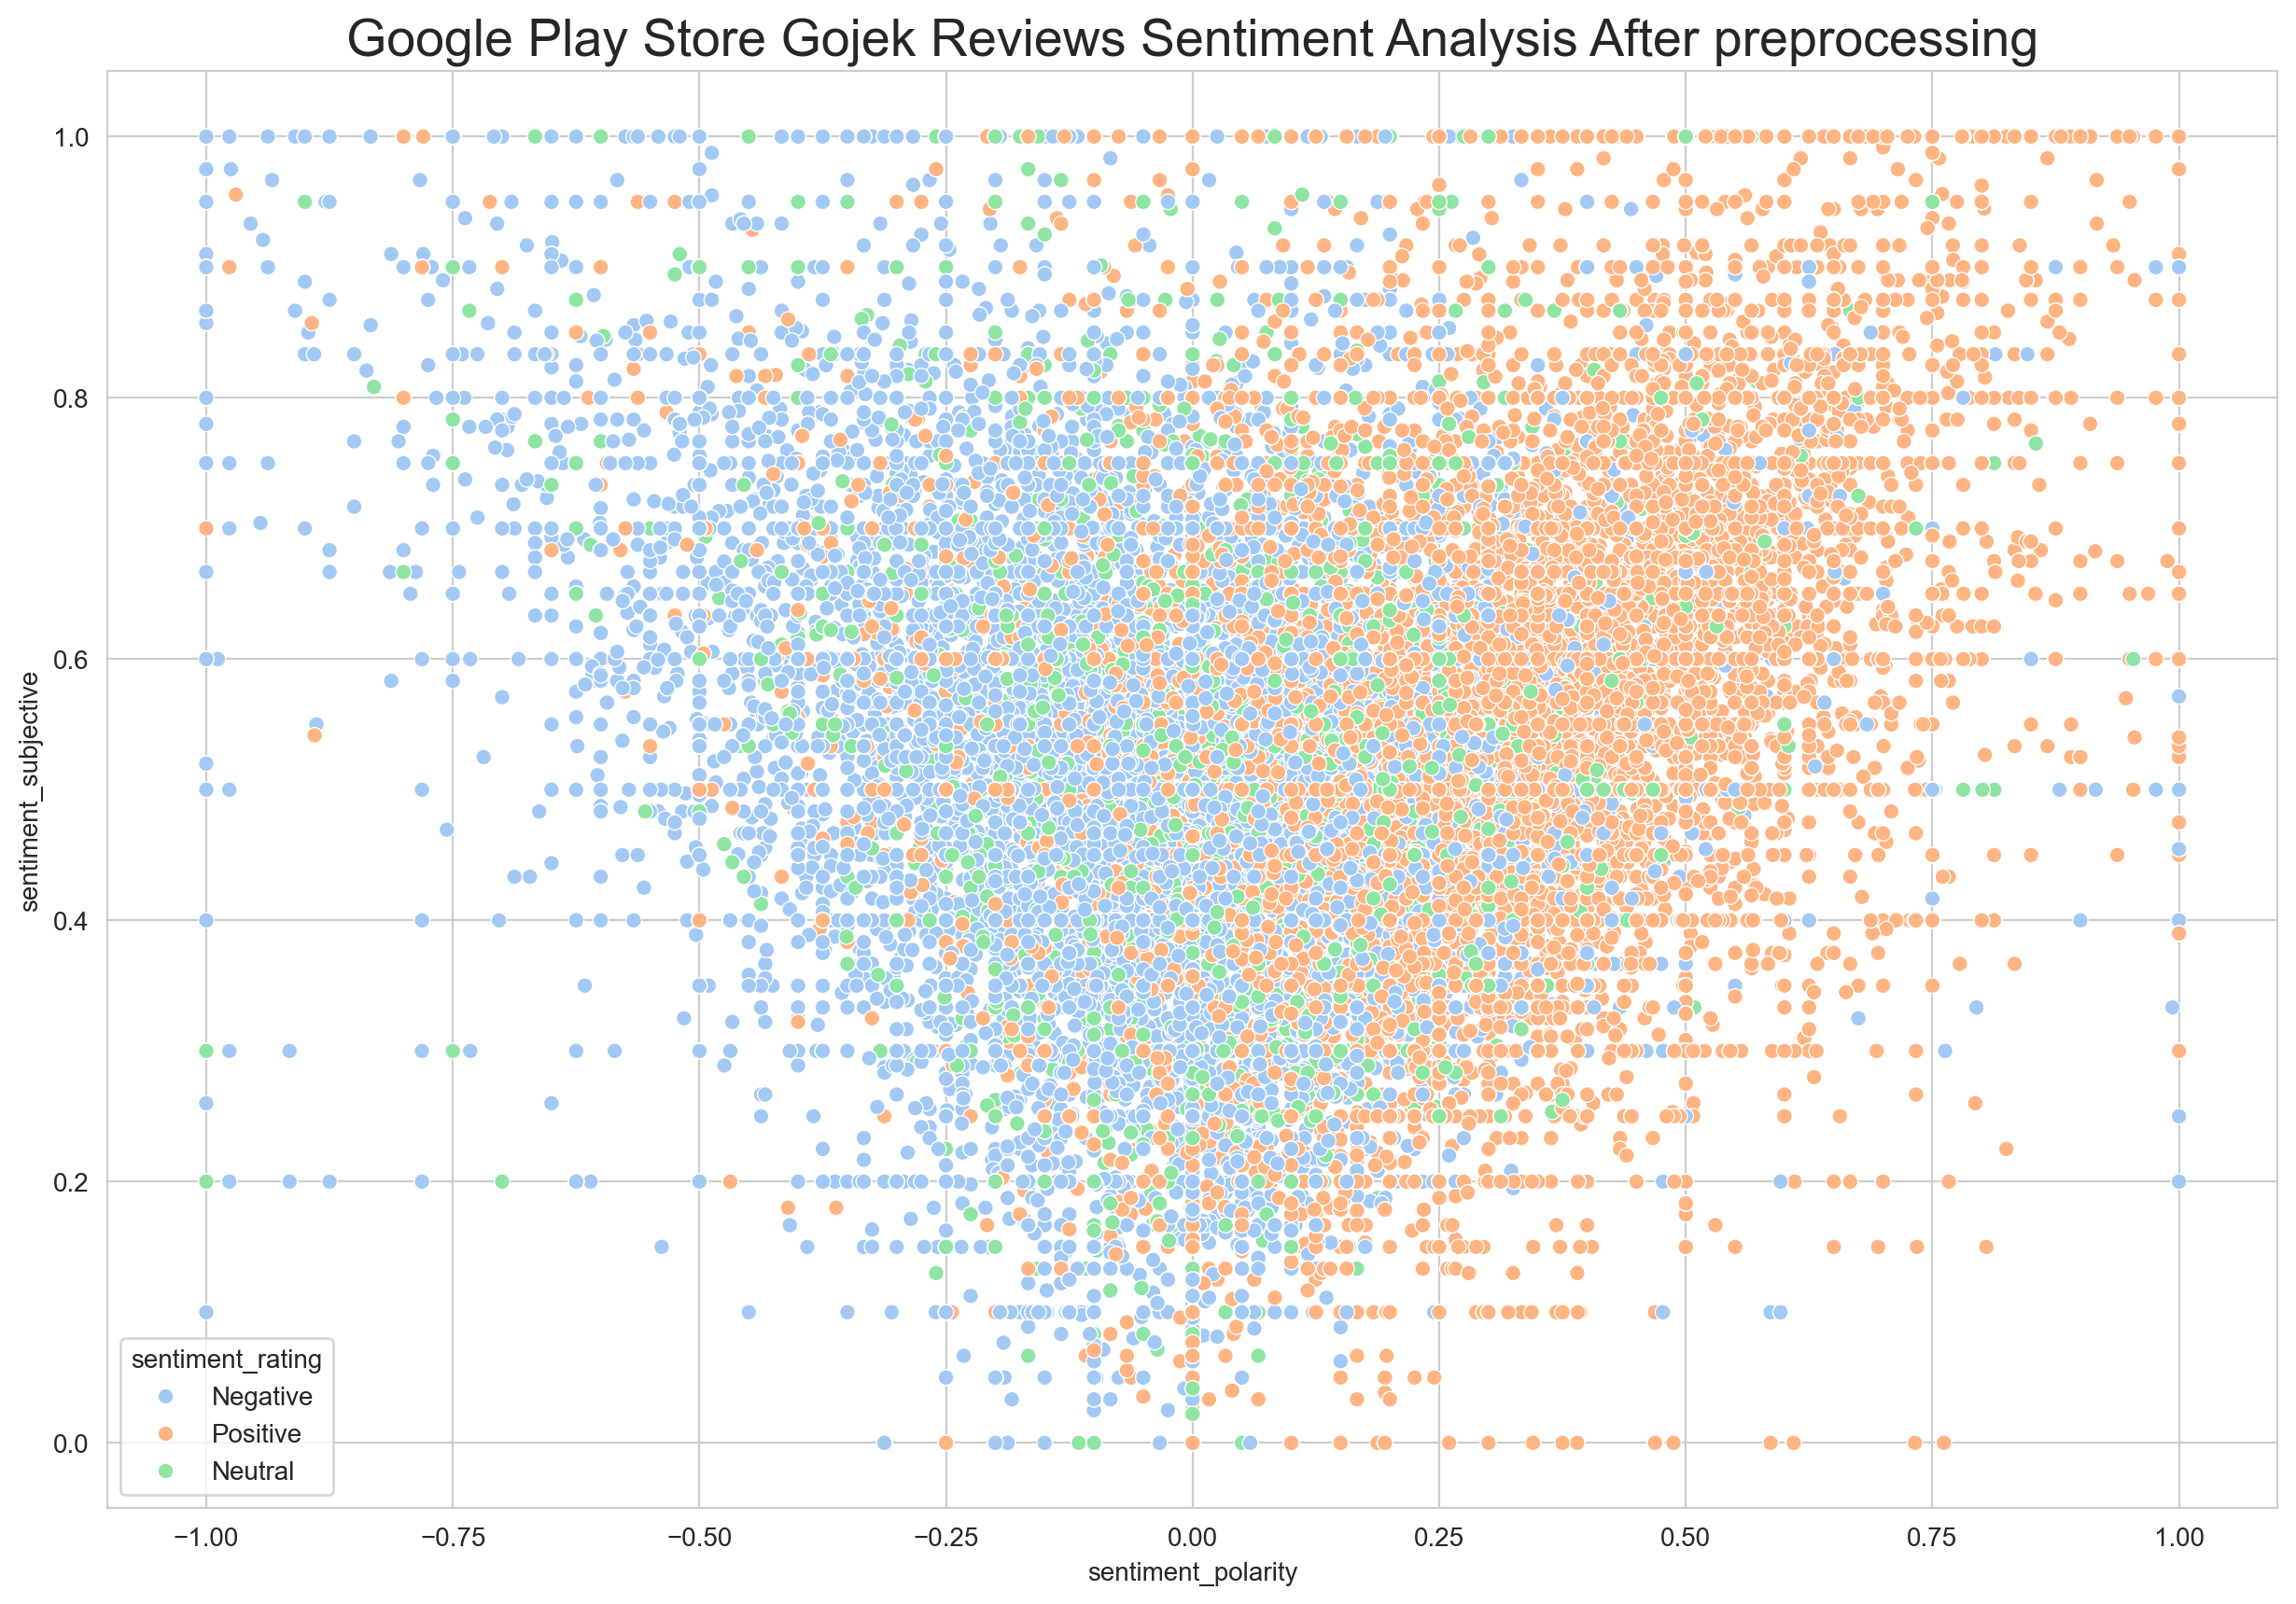

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_gjkrev['sentiment_polarity'], y=df_gjkrev['sentiment_subjective'],
                hue=df_gjkrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store Gojek Reviews Sentiment Analysis After preprocessing", fontsize=20)
plt.show()

In [ ]:
# Save the cleaned DataFrame to a new CSV file
df_gjkrev.to_csv(r'data/df_gjkrev_clean.csv', index=False)

# #4 Filter hanya Komen Netral/Negatif #

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
df = pd.read_csv("data/df_gjkrev_clean.csv")
print("Dataset shape before:", df.shape)

# Keep only necessary columns
df = df[['content', 'score']].dropna()
print("Dataset shape after:", df.shape)
df.head()


Dataset shape before: (226339, 18)
Dataset shape after: (222120, 2)


C:\Users\HiliCe\AppData\Local\Temp\ipykernel_16524\1413329488.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/df_gjkrev_clean.csv")


content  score
0  pretty useless when ordering grabmark kilat. i...      1
1  terlalu banyak notifikasi tidak diatur. piliha...      3
2             too many ads causes my phone buffering      4
3          user diizinkan melihat ratingnya sendiri?      2
4  quite disappointed with the one tap service. i...      3

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

df['sentiment'] = df['clean_text'].apply(get_sentiment)

# Keep only negative/neutral reviews (complaints)
complaints = df[df['sentiment'] <= 0]
print("Complaint reviews:", len(complaints))

Dataset shape after: (206732, 3)
sentiment
1    141260
0     65472
Name: count, dtype: int64


In [ ]:
# TF-IDF Vectorization (Dengan N-grams)
vectorizer = TfidfVectorizer(
    max_df=0.9,          # ignore terms appearing in >90% docs
    min_df=5,            # ignore rare words
    ngram_range=(1, 2),  # use words and common phrases
    stop_words='english'
)

tfidf_matrix = vectorizer.fit_transform(complaints['clean_text'])
print("TF-IDF matrix shape:", tfidf_matrix.shape)

In [ ]:
# Topic Modeling 
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
lda.fit(tfidf_matrix)

# Get feature names (words)
terms = vectorizer.get_feature_names_out()

def show_topics(model, feature_names, num_words=10):
    for idx, topic in enumerate(model.components_):
        top_terms = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        print(f"Topic {idx+1}: {', '.join(top_terms)}")

show_topics(lda, terms)

In [ ]:
# Tampilkan 5 contoh keluhan
for i in range(5):
    print(f"\n--- Example Complaint {i+1} ---")
    print(complaints.iloc[i]['review_text'])